In [1]:
import pandas as pd
import numpy as np 
import requests
import pandas as pd

In [2]:
# NOTE: There is no need to fetch this dataset multiple times. The CPI_quarterly dataset will be saved separately in data. 

# USING BLS API TO GET MONTHLY CPI DATA 
series_id = "CUUR0000SA0"  # CPI-U, all items, not seasonally adjusted
payload = {
    "seriesid": [series_id],
    "startyear": "2015",
    "endyear": "2024"
}
url = "https://api.bls.gov/publicAPI/v2/timeseries/data/"
response = requests.post(url, json=payload)
response.raise_for_status()
data = response.json()

records = data["Results"]["series"][0]["data"]
df = pd.DataFrame([
    {
        "year": int(r["year"]),
        "month": int(r["period"][1:]),
        "CPI": float(r["value"])
    }
    for r in records if r["period"].startswith("M")
])
df["date"] = pd.to_datetime(df[["year", "month"]].assign(day=1))
df = df.sort_values("date").set_index("date")[["CPI"]]

cpi_quarterly = df.resample("Q").mean()
cpi_quarterly.index = cpi_quarterly.index.to_period("Q")

print(cpi_quarterly.head())

cpi_quarterly.to_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/cpi_quarterly_only.csv")

               CPI
date              
2015Q1  234.849333
2015Q2  237.680667
2015Q3  238.305000
2015Q4  237.233000
2016Q1  237.386333


/tmp/ipykernel_16216/1516576215.py:27: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  cpi_quarterly = df.resample("Q").mean()


In [3]:
# Convert quarters to timestamps appropriately. 

cpi_quarterly = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/cpi_quarterly_only.csv")

cpi_quarterly['ds'] = pd.PeriodIndex(cpi_quarterly['date'], freq='Q').to_timestamp(how="end")

cpi_quarterly = cpi_quarterly[['ds','CPI']]
cpi_quarterly.head()

,ds,CPI
0,2015-03-31 23:59:59.999999999,234.849333
1,2015-06-30 23:59:59.999999999,237.680667
2,2015-09-30 23:59:59.999999999,238.305000
3,2015-12-31 23:59:59.999999999,237.233000
4,2016-03-31 23:59:59.999999999,237.386333


In [4]:
# NOTE: using same offsetting logic to match cpi correctly. 
train_end = pd.Timestamp("2019-12-31")
covid_end = pd.Timestamp("2021-06-30")

cpi_train_pre_covid = cpi_quarterly[cpi_quarterly['ds'] <= train_end].copy()
cpi_post_covid_actual = cpi_quarterly[cpi_quarterly['ds'] > covid_end].copy()

# Calculate num of missing quarters
last_train_period = cpi_train_pre_covid['ds'].max().to_period('Q')
covid_end_period = covid_end.to_period('Q')
gap_quarters = (covid_end_period - last_train_period).n

print(f"Num gap quarters offset {gap_quarters}")


# Shift post-COVID CPI back by the same number of missing quarters
cpi_post_covid_actual['ds'] = cpi_post_covid_actual['ds'] - pd.offsets.QuarterEnd(gap_quarters)
cpi_reindexed = (pd.concat([cpi_train_pre_covid, cpi_post_covid_actual]).sort_values(['ds']).drop_duplicates(subset=['ds']).reset_index(drop=True))

cpi_reindexed.head()

Num gap quarters offset 7


,ds,CPI
0,2015-03-31 23:59:59.999999999,234.849333
1,2015-06-30 23:59:59.999999999,237.680667
2,2015-09-30 23:59:59.999999999,238.305000
3,2015-12-31 23:59:59.999999999,237.233000
4,2016-03-31 23:59:59.999999999,237.386333


The normalization using cpi is known to be: 

$$\text{Real Revenue} = \frac{\text{Nominal Revenue}}{\text{CPI (current period)}} \times 100$$

Where 100 represents the 'baseline' CPI. 

The following code merges the reindexed csv with the reindexed cpi dataframe. The y values will then be normalized. 

In [5]:
df_reindexed = pd.read_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/reindexed.csv")
df_reindexed = df_reindexed[['unique_id', 'ds', 'y']]
df_reindexed['ds'] = pd.to_datetime(df_reindexed['ds'])

df_reindexed = df_reindexed.merge(cpi_reindexed.rename(columns={"CPI": "CPI_current"}),on='ds',how='left')

# base_period = df_reindexed[df_reindexed['ds'] <= train_end]['ds'].max()
base_period = df_reindexed['ds'].max()
print(base_period)


base_cpi = df_reindexed.loc[df_reindexed['ds'] == base_period, "CPI_current"].values[0]
# base_cpi = 100

print(f"Base cpi is {base_cpi}")

df_reindexed['y_real'] = df_reindexed['y'] / df_reindexed['CPI_current'] * base_cpi

df_reindexed['y'] = df_reindexed['y_real']

df_reindexed = df_reindexed.drop(['y_real', 'CPI_current'], axis=1)

df_reindexed.head()

2023-03-31 23:59:59.999999999
Base cpi is 315.58733333333333


,unique_id,ds,y
0,Alaska,2015-03-31 23:59:59.999999999,31828.923980
1,Alaska,2015-06-30 23:59:59.999999999,40118.834276
2,Alaska,2015-09-30 23:59:59.999999999,45194.389227
3,Alaska,2015-12-31 23:59:59.999999999,32973.756734
4,Alaska,2016-03-31 23:59:59.999999999,40526.192617


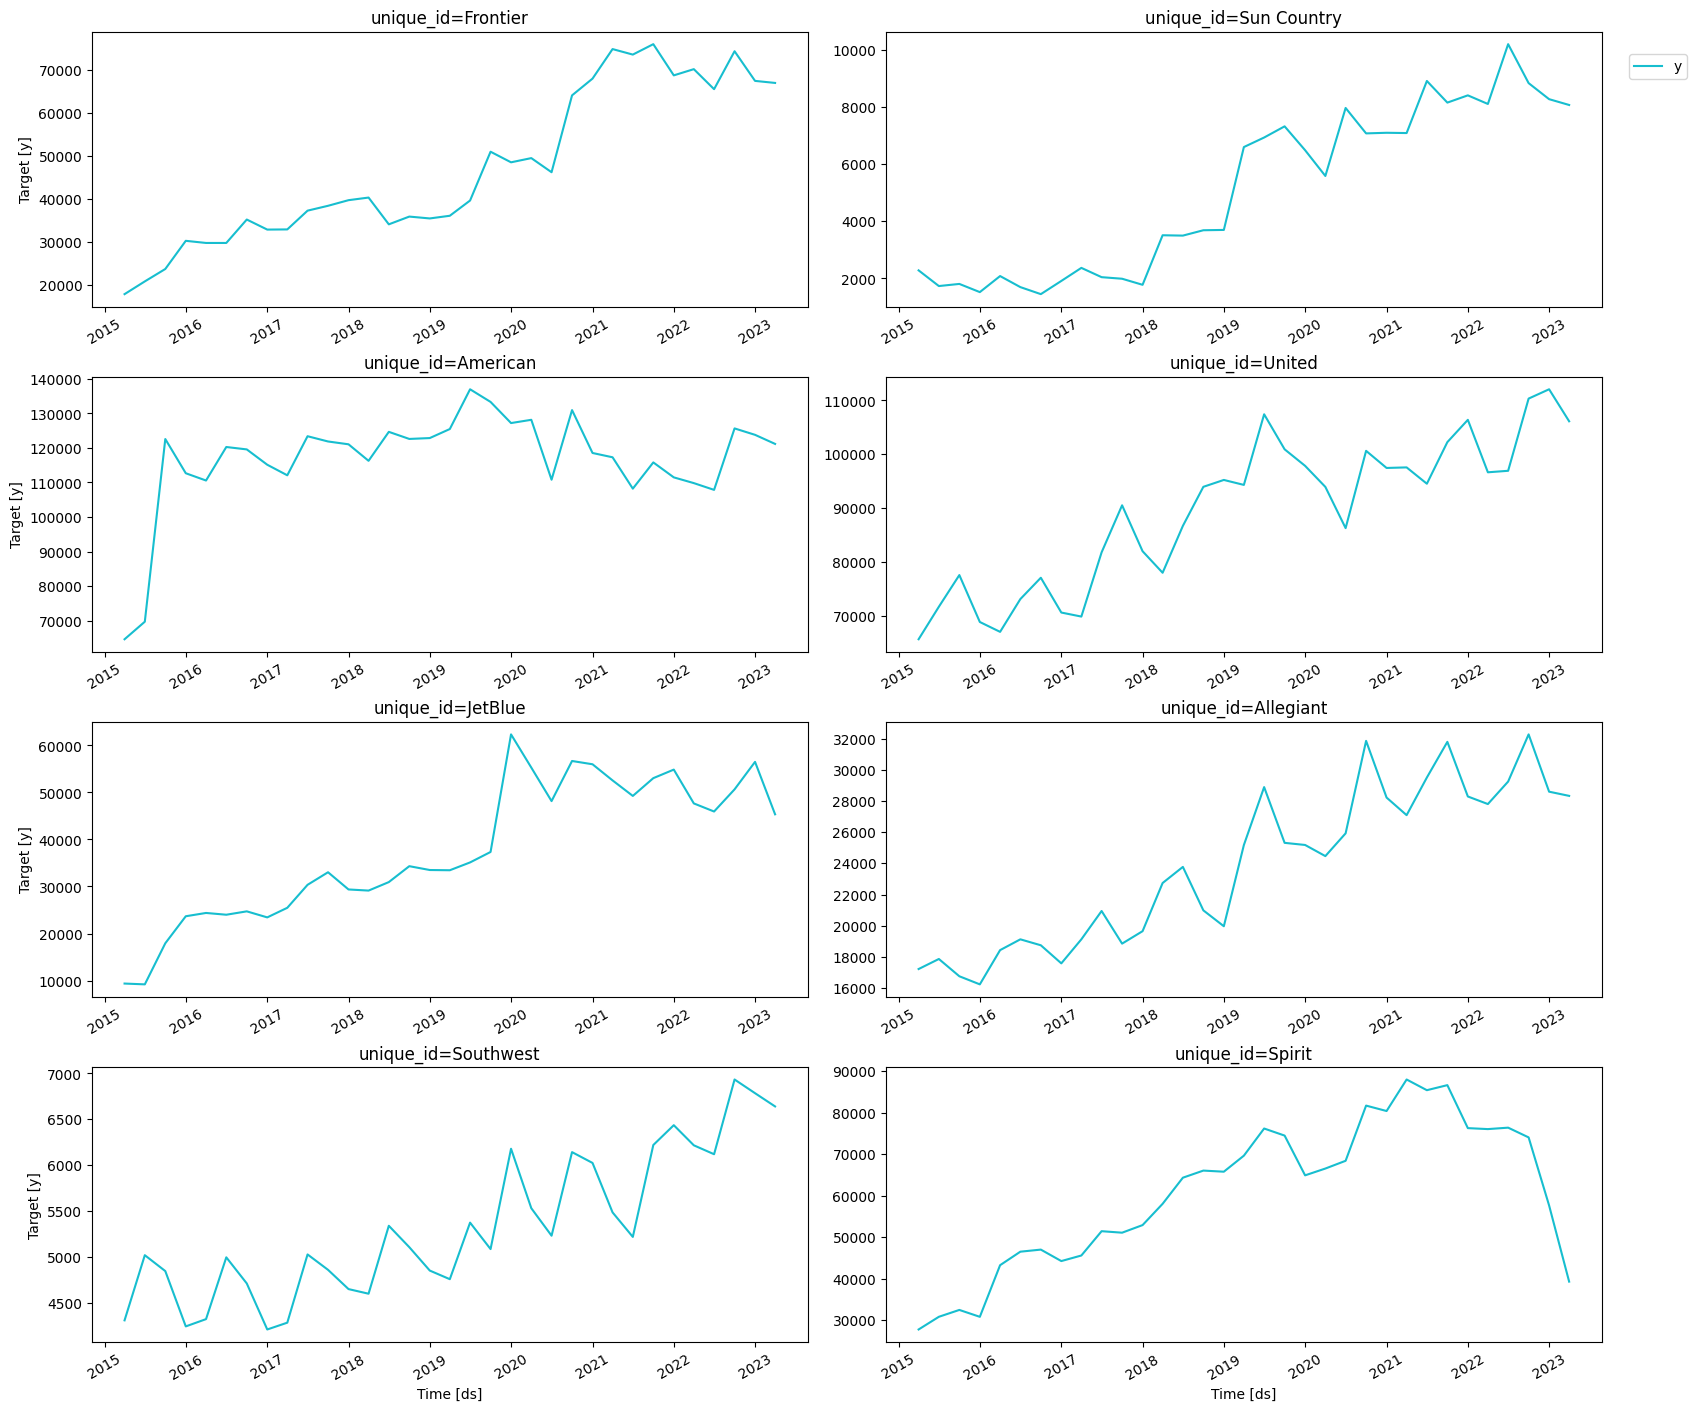

In [19]:
from utilsforecast.plotting import plot_series

plot_series(df=df_reindexed)

In [8]:
df_reindexed.to_csv(r"/home/rayan/Southwest_stuff/BaggageRevenueModel/data/reindexed_norm.csv")